In [80]:
#TOPIC MODELING
#LDA topic modeling with sklearn
import re
import pandas as pd

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

In [82]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [83]:
import sys
sys.path.append('/Users/dariamartinovskaya/Downloads/PLN')
from Chapter04.preprocess_bbc_dataset import get_stopwords
stopwords_file_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter01/stopwords.csv"
stopwords = get_stopwords(stopwords_file_path)
bbc_dataset = "/Users/dariamartinovskaya/Downloads/PLN/Chapter04/bbc-text.csv"

In [84]:
os.chdir('/Users/dariamartinovskaya/Downloads/PLN')
from Chapter04.unsupervised_text_classification import tokenize_and_stem
stopwords_file_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter01/stopwords.csv"
stopwords = get_stopwords(stopwords_file_path)
bbc_dataset = "/Users/dariamartinovskaya/Downloads/PLN/Chapter04/bbc-text.csv"

In [85]:
def create_count_vectorizer(documents):
    count_vectorizer = \
    CountVectorizer(stop_words=stopwords, tokenizer=tokenize_and_stem)
    data = count_vectorizer.fit_transform(documents)
    return (count_vectorizer, data)

In [86]:
def clean_data(df):
    df['text'] = \
    df['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df['text'] = \
    df['text'].apply(lambda x: re.sub(r'\d', '', x))
    return df

In [87]:
def create_and_fit_lda(data, num_topics):
    lda = LDA(n_components=num_topics, n_jobs=-1)
    lda.fit(data)
    return lda

In [88]:
def get_most_common_words_for_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out() 
    word_dict = {}
    for topic_index, topic in enumerate(model.components_):
        word_dict[f"Topic {topic_index}"] = [words[i] for i in topic.argsort()[-n_top_words:]]
    return word_dict

In [89]:
def print_topic_words(word_dict):
    for key in word_dict.keys():
        print(f"Topic {key}")
        print("\t", word_dict[key])

In [90]:
df = pd.read_csv(bbc_dataset)
df = clean_data(df)
documents = df['text']

In [91]:
number_topics = 5

In [92]:
(vectorizer, data) = create_count_vectorizer(documents)
lda = create_and_fit_lda(data, number_topics)

/opt/anaconda3/envs/dariaenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/dariaenv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'el', 'elsewh', 'everywh', 'l', 'otherwi', 'plea', 'somewh', 'v', 'wor'] not in stop_words.
  warnings.warn(


In [93]:
topic_words = \
get_most_common_words_for_topics(lda, vectorizer, 10)
print_topic_words(topic_words)

Topic Topic 0
	 ['servic', 'phone', 'make', 'mobil', 'new', 'technolog', 'music', 'game', 'peopl', 'use']
Topic Topic 1
	 ['tori', 'blair', 'plan', 'peopl', 'minist', 'parti', 'labour', 'elect', 'say', 'govern']
Topic Topic 2
	 ['player', 'wale', 'back', 'world', 'first', 'win', 'game', 'play', 'england', 'year']
Topic Topic 3
	 ['month', 'share', 'price', 'sale', 'm', 'firm', 'market', 'compani', 'bn', 'year']
Topic Topic 4
	 ['won', 'play', 'win', 'time', 'star', 'award', 'best', 'year', 'm', 'film']


In [94]:
 import pickle

In [95]:
model_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter06/lda_sklearn.pkl"
vectorizer_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter06/vectorizer.pkl"

In [96]:
new_example = """Manchester United players slumped to the turf at full-time in Germany on Tuesday in acknowledgement of what their latest pedestrian first- half display had cost them. The 3-2 loss at RB Leipzig means United will not be one of the 16 teams in the draw for the knockout stages of the Champions League. And this is not the only price for failure. The damage will be felt in the accounts, in the dealings they have with current and potentially future players and in the faith the fans have placed in manager Ole Gunnar Solskjaer. With Paul Pogba's agent angling for a move for his client and ex-United defender Phil Neville speaking of a "witchhunt" against his former team-mate Solskjaer, BBC Sport looks at the ramifications and reaction to a big loss for United."""

In [98]:
def save_model(lda, lda_path, vect, vect_path):
    pickle.dump(lda, open(lda_path, 'wb'))
    pickle.dump(vect, open(vect_path, 'wb'))

In [99]:
def test_new_example(lda, vect, example):
    vectorized = vect.transform([example])
    topic = lda.transform(vectorized)
    print(topic)
    return topic

In [100]:
test_new_example(lda, vectorizer, new_example)

[[0.00345405 0.06308028 0.03867231 0.23318821 0.66160516]]


array([[0.00345405, 0.06308028, 0.03867231, 0.23318821, 0.66160516]])

In [253]:
#LDA topic modeling with gensim
import os
import re
import pandas as pd
from gensim.models.ldamodel import LdaModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from pprint import pprint
import nltk
from nltk.probability import FreqDist
from nltk.stem.snowball import SnowballStemmer

# from Chapter06.lda_topic import stopwords, bbc_dataset, clean_data

curerntPath = os.getcwd() 
stopwords_file_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter01/stopwords.csv"
stemmer = SnowballStemmer('english')

In [254]:
def read_in_csv(filename):
    file = open(filename, "r", encoding="utf-8")
    text = file.read()
    text = text.replace("\n", " ")
    words = nltk.tokenize.word_tokenize(text)
    freq_dist = FreqDist(word.lower() for word in words)
    words_with_frequencies = [(word, freq_dist[word]) for word in freq_dist.keys()]
    sorted_words = sorted(words_with_frequencies, key=lambda tup: tup[1])
    length_cutoff = int(0.02*len(sorted_words))
    stopwords = [tuple[0] for tuple in sorted_words[-length_cutoff:]]
    return stopwords

In [255]:
def get_stopwords(path=stopwords_file_path):
    stopwords = read_in_csv(path)
    stopwords = [word[0] for word in stopwords]
    stemmed_stopwords = [stemmer.stem(word) for word in stopwords]
    stopwords = stopwords + stemmed_stopwords
    return stopwords

stopwords = get_stopwords(stopwords_file_path)
bbc_dataset = os.path.join(curerntPath, "/Users/dariamartinovskaya/Downloads/PLN/Chapter04/bbc-text.csv")

In [256]:
def clean_data(df):
    df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    df['text'] = df['text'].apply(lambda x: re.sub(r'\d', '', x))
    return df

In [257]:
def preprocess(df):
    df = clean_data(df)
    df['text'] = df['text'].apply(lambda x: simple_preprocess(x, deacc=True))
    df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])
    return df

In [258]:
def create_lda_model(id_dict, corpus, num_topics):
    lda_model = LdaModel(corpus=corpus,
        id2word=id_dict,
        num_topics=num_topics,
        random_state=100,
        chunksize=100,
        passes=10)
    return lda_model

In [259]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)

In [260]:
texts = df['text'].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

In [261]:
number_topics = 5
lda_model = create_lda_model(id_dict, corpus, number_topics)

In [262]:
pprint(lda_model.print_topics())

[(0,
  '0.059*"the" + 0.020*"and" + 0.020*"in" + 0.019*"of" + 0.018*"film" + '
  '0.015*"for" + 0.012*"best" + 0.009*"was" + 0.009*"at" + 0.007*"awards"'),
 (1,
  '0.070*"the" + 0.036*"to" + 0.028*"of" + 0.022*"and" + 0.017*"in" + '
  '0.013*"said" + 0.012*"that" + 0.010*"for" + 0.010*"is" + 0.010*"on"'),
 (2,
  '0.056*"the" + 0.033*"to" + 0.029*"of" + 0.025*"and" + 0.017*"in" + '
  '0.014*"that" + 0.013*"is" + 0.012*"it" + 0.010*"are" + 0.010*"for"'),
 (3,
  '0.059*"the" + 0.030*"to" + 0.024*"in" + 0.023*"and" + 0.017*"of" + '
  '0.013*"he" + 0.011*"it" + 0.011*"for" + 0.010*"on" + 0.010*"is"'),
 (4,
  '0.061*"the" + 0.038*"in" + 0.025*"of" + 0.022*"to" + 0.015*"and" + '
  '0.011*"its" + 0.011*"bn" + 0.010*"said" + 0.010*"at" + 0.009*"us"')]


In [263]:
new_example = """Manchester United players slumped to the turf at full-time in Germany on Tuesday in acknowledgement of what their latest pedestrian first-half display had cost them. The 3-2 loss at RB Leipzig means United will not be one of the 16 teams in the draw for the knockout stages of the Champions League. And this is not the only price for failure. The damage will be felt in the accounts, in the dealings they have with current and potentially future players and in the faith the fans have placed in manager Ole Gunnar Solskjaer. With Paul Pogba's agent angling for a move for his client and ex-United defender Phil Neville speaking of a "witchhunt" against his former team-mate Solskjaer, BBC Sport looks at the ramifications and reaction to a big loss for United."""

In [270]:
def save_model(lda, lda_path, id_dict, dict_path):
    lda.save(lda_path)
    id_dict.save(dict_path)

corpus = [id_dict.doc2bow(text) for text in texts]
id_dict = corpora.Dictionary(texts)
lda_model = create_lda_model(id_dict, corpus, number_topics)
lda_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter06/lda_gensim.model"
dict_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter06/id2word.dict"
corpus_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter06/corpus.mm"
print(f"LDA model saved: {os.path.exists(lda_path)}")
print(f"Dictionary saved: {os.path.exists(dict_path)}")
print(f"Corpus saved: {os.path.exists(corpus_path)}")

LDA model saved: True
Dictionary saved: True
Corpus saved: True


In [265]:
def load_model(lda_path, dict_path):
    lda = LdaModel.load(lda_path)
    id_dict = corpora.Dictionary.load(dict_path)
    return (lda, id_dict)

In [266]:
def test_new_example(lda, id_dict, input_string):
    input_list = clean_text(input_string)
    bow = id_dict.doc2bow(input_list)
    topics = lda[bow]
    print(topics)
    return topics

In [267]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(input_string):
    input_string = input_string.lower()
    
    input_string = re.sub(r'[^\w\s]', '', input_string)
    
    tokens = word_tokenize(input_string)
    
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [word for word in tokens if word not in stop_words]
    
    return cleaned_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dariamartinovskaya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dariamartinovskaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [268]:
lda_model.save(lda_path)  
id_dict.save(dict_path)   
corpora.MmCorpus.serialize(corpus_path, corpus)  

In [269]:
test_new_example(lda_model, id_dict, new_example)

[(1, 0.17702451), (3, 0.7484408), (4, 0.06738019)]


[(1, 0.17702451), (3, 0.7484408), (4, 0.06738019)]

In [216]:
#NMF topic modeling
import re
import pandas as pd
from gensim.models.nmf import Nmf
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from pprint import pprint
from Chapter06.lda_topic_sklearn import stopwords, bbc_dataset, new_example
from Chapter06.lda_topic_gensim import preprocess, test_new_example

In [218]:
def create_nmf_model(id_dict, corpus, num_topics):
    nmf_model = Nmf(corpus=corpus, id2word=id_dict, num_topics=num_topics, random_state=100, chunksize=100, passes=50)
    return nmf_model

In [220]:
def plot_coherence(id_dict, corpus, texts):
    num_topics_range = range(2, 10)
    coherences = []
    for num_topics in num_topics_range:
        nmf_model = create_nmf_model(id_dict, corpus, num_topics)
        coherence_model_nmf = \
        CoherenceModel(model=nmf_model, texts=texts, dictionary=id_dict, coherence='c_v')
        coherences.append(coherence_model_nmf.get_coherence())
    plt.plot(num_topics_range, coherences, color='blue', marker='o', markersize=5)
    plt.title('Coherence as a function of number of \\ topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid()
    plt.show()

In [222]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)

In [224]:
texts = df['text'].values
id_dict = corpora.Dictionary(texts)
corpus = [id_dict.doc2bow(text) for text in texts]

In [226]:
number_topics = 5
nmf_model = create_nmf_model(id_dict, corpus, number_topics)

In [227]:
pprint(nmf_model.print_topics())

[(0,
  '0.017*"people" + 0.013*"music" + 0.008*"mobile" + 0.006*"technology" + '
  '0.005*"digital" + 0.005*"phone" + 0.005*"tv" + 0.005*"use" + 0.004*"users" '
  '+ 0.004*"net"'),
 (1,
  '0.017*"labour" + 0.014*"party" + 0.013*"election" + 0.012*"blair" + '
  '0.009*"brown" + 0.008*"government" + 0.008*"people" + 0.007*"minister" + '
  '0.006*"howard" + 0.006*"tax"'),
 (2,
  '0.009*"government" + 0.008*"bn" + 0.007*"new" + 0.007*"year" + '
  '0.004*"company" + 0.003*"uk" + 0.003*"last" + 0.003*"state" + 0.003*"yukos" '
  '+ 0.003*"market"'),
 (3,
  '0.029*"best" + 0.016*"song" + 0.012*"film" + 0.011*"years" + 0.009*"music" '
  '+ 0.009*"last" + 0.009*"awards" + 0.008*"year" + 0.008*"won" + '
  '0.008*"angels"'),
 (4,
  '0.012*"game" + 0.008*"first" + 0.007*"time" + 0.007*"games" + '
  '0.006*"england" + 0.006*"new" + 0.006*"world" + 0.005*"wales" + '
  '0.005*"play" + 0.004*"back"')]


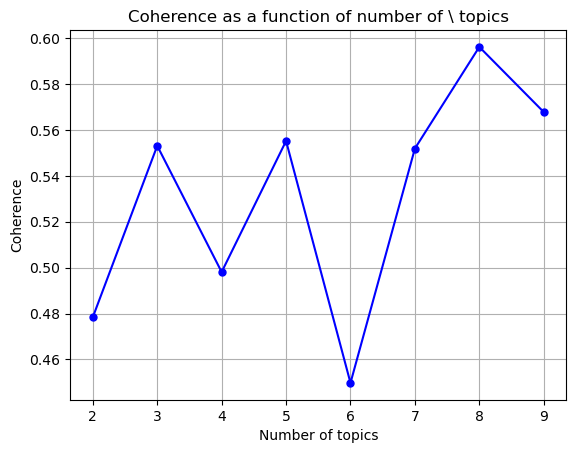

In [232]:
plot_coherence(id_dict, corpus, texts)

In [234]:
test_new_example(nmf_model, id_dict, new_example)

[(2, 0.09938121851363546), (4, 0.9006187814863645)]


In [239]:
#K-means topic modeling with BERT
import re
import string
import pandas as pd
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from Chapter01.tokenization import tokenize_nltk
from Chapter04.preprocess_bbc_dataset import get_data
from Chapter04.keyword_classification import divide_data
from Chapter04.preprocess_bbc_dataset import get_stopwords
from Chapter04.unsupervised_text_classification import get_most_frequent_words, print_most_common_words_by_cluster
from Chapter06.lda_topic_sklearn import stopwords, bbc_dataset, new_example
from Chapter06.lda_topic_gensim import preprocess
from sentence_transformers import SentenceTransformer

In [240]:
bbc_dataset = "/Users/dariamartinovskaya/Downloads/PLN/Chapter04/bbc-text.csv"
stopwords_file_path = "/Users/dariamartinovskaya/Downloads/PLN/Chapter01/stopwords.csv"
stopwords = get_stopwords(stopwords_file_path)

In [241]:
def test_new_example(km, model, example):
    embedded = model.encode([example])
    topic = km.predict(embedded)[0]
    print(topic)
    return topic

In [242]:
df = pd.read_csv(bbc_dataset)
df = preprocess(df)
df['text'] = df['text'].apply(lambda x: " ".join(x))
documents = df['text'].values

In [246]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
encoded_data = model.encode(documents)

In [244]:
km = KMeans(n_clusters=5, random_state=0)
km.fit(encoded_data)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans(n_clusters=5, random_state=0)

In [245]:
print_most_common_words_by_cluster(documents, km, 5)

0
['year', 'bn', 'growth', 'economy', 'sales', 'economic', 'market', 'prices', 'government', 'last', 'rise', 'new', 'bank', 'dollar', 'rate', 'uk', 'world', 'figures', 'years', 'quarter', 'expected', 'rates', 'spending', 'profits', 'oil', 'months', 'people', 'december', 'month', 'increase', 'analysts', 'rose', 'strong', 'interest', 'jobs', 'time', 'high', 'tax', 'first', 'three', 'china', 'fall', 'company', 'january', 'budget', 'price', 'business', 'report', 'million', 'next', 'trade', 'demand', 'chief', 'hit', 'higher', 'firm', 'fell', 'costs', 'shares', 'consumer', 'country', 'deficit', 'low', 'cut', 'record', 'recent', 'added', 'biggest', 'cost', 'countries', 'exports', 'europe', 'profit', 'annual', 'set', 'euro', 'debt', 'inflation', 'financial', 'november', 'back', 'markets', 'president', 'south', 'domestic', 'group', 'euros', 'economist', 'level', 'number', 'earlier', 'end', 'data', 'stock', 'european', 'house', 'good', 'india', 'news', 'five', 'minister', 'share', 'continue', 'g

,text,cluster
2,tv future hands viewers home theatre systems p...,2
1,worldcom boss left books alone former worldcom...,1
3,tigers wary farrell gamble leicester say rushe...,3
4,yeading face newcastle fa cup premiership side...,4
4,ocean twelve raids box office ocean twelve cri...,4
...,...,...
0,cars pull retail figures retail sales fell jan...,0
1,kilroy unveils immigration policy ex chatshow ...,1
3,rem announce new glasgow concert band rem anno...,3
1,political squabbles snowball become commonplac...,1


In [247]:
test_new_example(km, model, new_example)

3


3